In [1]:
from helpers_given import *
from preprocess import *
from helpers import *
import seaborn as sns

Load data with helpers_given

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("dataset/", sub_sample=False)

y_train loaded
x_train loaded
x_test loaded


In [3]:
nb_col = x_train.shape[1]
nb_rows = x_train.shape[0]

In [4]:
y_01 = convert_minus1_to_0(y_train)

In [5]:
print(y_01)
print(y_01[y_01==0].shape)
print(y_01[y_01==1].shape)

[0. 0. 0. ... 0. 0. 0.]
(299160,)
(28975,)


In [6]:
with open('dataset/x_train.csv', 'r') as f:
    features_string = f.readline()
    features = features_string.split(',')
features = features[1:]

Preprocessing of run.py

In [7]:
nb_nans = np.zeros(nb_col)
for i, col in enumerate(x_train.T):
    nb_nans[i] = np.count_nonzero(np.isnan(col))

In [8]:
#nb_nans = number_of_NaNs(features, x_train)
reduced_data, reduced_features, Removed_features = removing_features(nb_nans, features, x_train, threshold=0.2)
#need to apply the same transfo to x_test
reduced_test = np.delete(x_test, Removed_features, 1)

In [9]:
# Get feature correlation dictionary
feature_correlation_dict = create_dictionary_from_correlation(reduced_data,reduced_features,0.6)

max_corrr_feature_dict = {}

for key, val in feature_correlation_dict.items():
    max_corrr_feature_dict[key] = len(val)

# Sort the dictionary by value in descending order
max_corrr_feature_dict = {k: v for k, v in sorted(max_corrr_feature_dict.items(), key=lambda item: item[1], reverse=True)}

 Finished for feature: _STATE
 Finished for feature: FMONTH
 Finished for feature: IDATE
 Finished for feature: IMONTH
 Finished for feature: IDAY
 Finished for feature: IYEAR
 Finished for feature: DISPCODE
 Finished for feature: SEQNO
 Finished for feature: _PSU
 Finished for feature: GENHLTH
 Finished for feature: PHYSHLTH
 Finished for feature: MENTHLTH
 Finished for feature: HLTHPLN1
 Finished for feature: PERSDOC2
 Finished for feature: MEDCOST
 Finished for feature: CHECKUP1
 Finished for feature: BPHIGH4
 Finished for feature: BLOODCHO
 Finished for feature: CHOLCHK
 Finished for feature: TOLDHI2
 Finished for feature: CVDSTRK3
 Finished for feature: ASTHMA3
 Finished for feature: CHCSCNCR
 Finished for feature: CHCOCNCR
 Finished for feature: CHCCOPD1
 Finished for feature: HAVARTH3
 Finished for feature: ADDEPEV2
 Finished for feature: CHCKIDNY
 Finished for feature: DIABETE3
 Finished for feature: SEX
 Finished for feature: MARITAL
 Finished for feature: EDUCA
 Finished for 

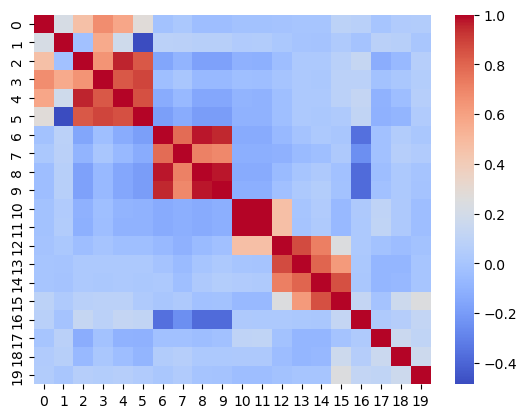

In [10]:
correlations = nan_corrcoef(reduced_data[:, 80:100])
# plt.figure(figsize=(20,20))
sns.heatmap(correlations, cmap="coolwarm")
plt.show()

In [11]:
features_to_drop = []
for key in max_corrr_feature_dict.keys():
    features_to_drop.append(key)
    if len(features_to_drop) == 30:
        break

# Define features to keep
features_to_keep = []
for feature in reduced_features:
    if feature not in features_to_drop:
        features_to_keep.append(feature)

# Also replace some features with their calculated counterparts
origin_calculated_features = {
    'WEIGHT2' : 'WTKG3',
    'HEIGHT3' : 'HTM4',
    'ALCDAY5' : '_DRNKWEK',
    'FRUITJU1' : 'FTJUDA1_',
    'FRUIT1' : 'FRUTDA1_',
    'FVBEANS' : 'BEANDAY_',
    'FVGREEN' : 'GRENDAY_',
    'FVORANG' : 'ORNGDAY_',
    'VEGETAB1' : 'VEGEDA1_',
    'STRENGTH' : 'STRFREQ_'
}

# In features_to_keep replace the key of origin_calculated_features with the value
for key, val in origin_calculated_features.items():
    for i, feature in enumerate(features_to_keep):
        if key == feature:
            features_to_keep[i] = val

# Drop duplicates
features_to_keep = list(set(features_to_keep))

# Get the indices of the selected features
selected_features_indices = []
selected_features_indices_original = []
for feature in features_to_keep:
    selected_features_indices.append(reduced_features.index(feature))
    selected_features_indices_original.append(features.index(feature))

selected_features_indices = sorted(selected_features_indices)
selected_features_indices_original = sorted(selected_features_indices_original)



In [12]:
# Create a new dataset with keeping the features that are in the selected_features_indices
reduced_data = reduced_data[:,selected_features_indices]
reduced_test = reduced_test[:,selected_features_indices]

# Also remove the features from the reduced_features list
reduced_features_2 = []
for feature in reduced_features:
    if feature in features_to_keep:
        reduced_features_2.append(feature)

# Remove redundant features
redundant_features = [ 'FMONTH','IDATE','IMONTH','IDAY','IYEAR', 'SEQNO', '_STATE', '_PSU', ]
# Get the indices of these features
redundant_features_indices = []
redundant_features_indices_original = []
for feature in redundant_features:
    if feature in reduced_features_2:
        redundant_features_indices.append(reduced_features_2.index(feature))
        redundant_features_indices_original.append(features.index(feature))

# Create a new dataset with removing the features that are in the selected_features_indices
reduced_data = np.delete(reduced_data, redundant_features_indices, 1)
reduced_features_2 = [reduced_features_2[i] for i in range(len(reduced_features_2)) if i not in redundant_features_indices]
reduced_test = np.delete(reduced_test, redundant_features_indices, 1)

# Replace nine values with NaNs
replace_nine_with_nan(reduced_data)
replace_nine_with_nan(reduced_test)

# Replace seven values with NaNs
replace_seven_with_nan(reduced_data)
replace_seven_with_nan(reduced_test)

# Replace 99 values with NaNs
replace_99_with_nan(reduced_data)
replace_99_with_nan(reduced_test)

# For the _DRNKWEK feature, replace 9990 with NaN
for i in range(reduced_data.shape[0]):
    if reduced_data[i, reduced_features_2.index('_DRNKWEK')] == 9990:
        reduced_data[i, reduced_features_2.index('_DRNKWEK')] = np.nan
for i in range(reduced_test.shape[0]):
    if reduced_test[i, reduced_features_2.index('_DRNKWEK')] == 9990:
        reduced_test[i, reduced_features_2.index('_DRNKWEK')] = np.nan

In [13]:
# Remove outliers
reduced_data = clean_outliers_modified(reduced_data)
reduced_test = clean_outliers_modified(reduced_test)

In [14]:
# Replace NaNs with medians
reduced_median = replace_NaN(reduced_data, method='median')
reduced_median_test = replace_NaN(reduced_test, method='median')

# Standardize the data
std_x_med = standardize_data(reduced_median)
std_test_med = standardize_data(reduced_median_test)

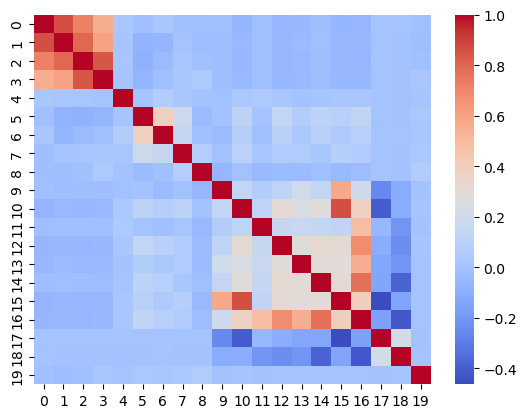

In [15]:
# plt.figure(figsize=(20,20))
sns.heatmap(np.corrcoef(reduced_median[:, 70:90].T), cmap="coolwarm")
plt.show()

In [16]:
len(reduced_features_2)

96

#### Run the methods

In [17]:
from implementations import *
NB_COL = std_x_med.shape[1] # corresponds to 'D' = number of features
NB_ROWS = std_x_med.shape[0] # corresponds to 'N' = number of observations/respondents

In [18]:
from cross_validation import *

In [38]:
# CV on two hyperparams degree and lambda on regularized logistic regression adding polynomial functi
seed = 12
degrees = [1]
k_fold = 4
lambdas = np.arange(0,0.51,0.01)
gamma = 0.5
max_iters = 50
initial_w = np.zeros(NB_COL)
k_indices = build_k_indices(y_01, k_fold, seed)
#for each degree, we compute the best lambdas and the associated rmse
best_lambdas = []
best_F1s = []
best_F1s_tr = []
best_lambdas_tr = []
plot_F1_te = np.zeros((len(degrees),len(lambdas)))
#vary degree
for degree in degrees:
    # cross validation
    F1_te = []
    F1_tr = []
    for lambda_ in lambdas:
        F1_te_tmp = []
        F1_tr_tmp = []
        for k in range(k_fold):
            F1_training, F1_test = cross_validation(y_01, std_x_med,initial_w, max_iters, gamma, k_indices, k, lambda_, degree)
            F1_te_tmp.append(F1_test)
            F1_tr_tmp.append(F1_training)
        F1_te.append(np.mean(F1_te_tmp))
        F1_tr.append(np.mean(F1_tr_tmp))
        plot_F1_te[degrees.index(degree),np.where(lambdas==lambda_)[0][0]] = np.mean(F1_te_tmp)
    print(f" Finished for degree: {degree}")
    ind_lambda_opt = np.argmax(F1_te)
    ind_lambda_opt_tr = np.argmax(F1_tr)
    best_lambdas.append(lambdas[ind_lambda_opt])
    best_lambdas_tr.append(lambdas[ind_lambda_opt_tr])
    best_F1s.append(F1_te[ind_lambda_opt])
    best_F1s_tr.append(F1_tr[ind_lambda_opt_tr])
ind_best =  np.nanargmax(best_F1s)      
best_degree = degrees[ind_best]
best_lambda = best_lambdas[ind_best]
best_F1 = best_F1s[ind_best]

 Finished for degree: 1


In [40]:
print(best_degree)
print(best_lambda)
print(best_F1)

1
0.5
0.392739181955439


### Plotting evolution of training and test F1-score as a function of lambda or degree

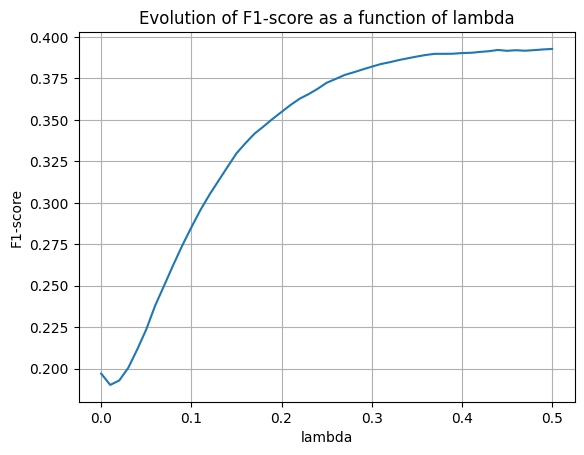

In [79]:
plt.plot(lambdas,F1_te)
plt.xlabel("lambda")
plt.ylabel("F1-score")
plt.title("Evolution of F1-score as a function of lambda")
plt.grid(True)
plt.savefig("F1-score_lambda")

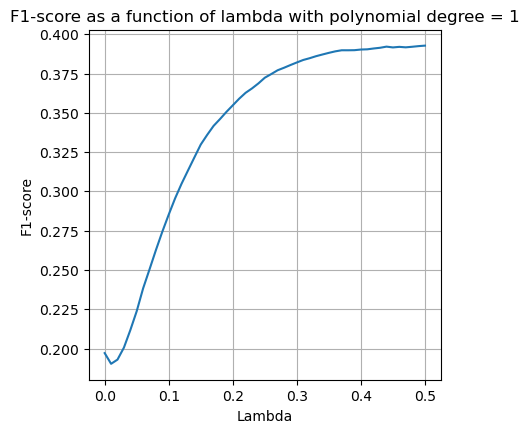

In [39]:
plt.figure(figsize=(10,10))
for i in range(len(degrees)):
    plt.subplot(2,2,i+1)
    plt.plot(lambdas,plot_F1_te[i,:])
    plt.xlabel('Lambda')
    plt.ylabel('F1-score')
    plt.title(f'F1-score as a function of lambda with polynomial degree = {degrees[i]}')
    plt.grid(True)
plt.show()

### Run regularized logistic regression with best param

In [80]:
tx = build_poly(std_x_med, best_degree)

In [81]:
size_w = tx.shape[1]

In [85]:
w_reg, loss_reg = reg_logistic_regression(y_01, tx, initial_w = np.zeros(size_w), max_iters = 100, gamma = 0.5, lambda_ = best_lambda)
print(loss_reg)
y_reg = convert_0_to_minus1(convert_predict(tx @ w_reg))
print(y_reg)
# accuracy
p_reg = compute_accuracy(y_train, y_reg) #percentage of false predictions
print(p_reg)

0.5496048072369548
[-1. -1. -1. ... -1. -1. -1.]
0.8621360110929953


In [53]:
w_reg.shape

(107,)

In [86]:
tx_test = build_poly(std_test_med, best_degree)
y_pred = convert_0_to_minus1(convert_predict(tx_test @ w_reg))

In [87]:
create_csv_submission(test_ids, y_pred, "new_result")

### F1-score and accuracy of all methods without hyperparameter finetuning

In [41]:
# GD
w_mse_gd, loss_mse_gd = mean_squared_error_gd(y_01, std_x_med, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.001)
y_mse_gd = convert_predict(std_x_med @ w_mse_gd)
print(f"The F1-score is: {compute_f1(y_01,y_mse_gd)} and the accuracy is : {compute_accuracy(y_01,y_mse_gd)}")

The F1-score is: 0.2965134887974394 and the accuracy is : 0.6249043838663965


In [42]:
# SGD
w_mse_sgd, loss_mse_sgd = mean_squared_error_sgd(y_01, std_x_med, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.001)
y_mse_sgd = convert_predict(std_x_med @ w_mse_sgd)
print(f"The F1-score is: {compute_f1(y_01,y_mse_sgd)} and the accuracy is : {compute_accuracy(y_01,y_mse_sgd)}")

The F1-score is: 0.2089142352087038 and the accuracy is : 0.5417495847745593


In [43]:
# Least squares
w_ls, loss_ls = least_squares(y_01, std_x_med)
y_ls = convert_predict(std_x_med @ w_ls)
print(f"The F1-score is: {compute_f1(y_01,y_ls)} and the accuracy is : {compute_accuracy(y_01,y_ls)}")

The F1-score is: 0.32035773591477024 and the accuracy is : 0.666969387599616


In [44]:
# Ridge regression
w_rr, loss_rr = ridge_regression(y_01, std_x_med, lambda_ = 0.5)
y_rr = convert_predict(std_x_med @ w_rr)
print(f"The F1-score is: {compute_f1(y_01,y_rr)} and the accuracy is : {compute_accuracy(y_01,y_rr)}")

The F1-score is: 0.3087834215936334 and the accuracy is : 0.6423941365596477


In [45]:
# logistic regression (GD)
w_lrgd, loss_lrgd = logistic_regression(y_01, std_x_med, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.001)
y_lrgd = convert_predict(std_x_med @ w_lrgd)
print(f"The F1-score is: {compute_f1(y_01,y_lrgd)} and the accuracy is : {compute_accuracy(y_01,y_lrgd)}")
#log sgd
#w_lrsgd, loss_lrsgd = logistic_regression_SGD(y_train, x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.1, lambda_ = 0.5)

The F1-score is: 0.2956390582239718 and the accuracy is : 0.6242857360537584


In [46]:
w_reg, loss_reg = reg_logistic_regression(y_01, std_x_med, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.001, lambda_ = 0.5)
y_reg = convert_predict(std_x_med @ w_reg)
print(f"The F1-score is: {compute_f1(y_01,y_reg)} and the accuracy is : {compute_accuracy(y_01,y_reg)}")
# reg log sgd
#w_reg_lrsgd, loss_reg_lrsgd = reg_logistic_regression_SGD(y_train, x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.1, lambda_ = 0.5)

The F1-score is: 0.29564541746175027 and the accuracy is : 0.6242826885275877
